# Test for decumulate IFS data

IFS fluxes are cumulated over monthly basis. This creates multiple issues in analysis.
We define a couple of funtions to check if a variale from IFS is a cumulative flux, and then another one to apply the derivative. 
So far it works, but it is too slow. Probably we need to remove the loop over the different month.
It could be quite easy to generalize to different cumulation time. 
We should adjust units (should be easy with metpy) and possibly change the name of the variables (more complicated to be done automatically)

In [50]:
from aqua import Reader
import xarray as xr
import numpy as np
#import copy

def check_cumulate(xfield):

    """To check if a field need is cumulated. Arbitrary check"""

    # randomly pick a few timesteps from a gridpoint
    diff = xfield[2:20,10].diff(dim='time').values
    return (diff >= 0).all()

# so far this works, but it is very slow
# evident problems are the loop and the deepcopy, it might be possible to simplify
def decumulate(xfield, cumulation_time = 3600):
    """
    Test function to remove cumulative effect on IFS fluxes
    """

    # fluxes are reset every month
    loops = np.unique(xfield.time.dt.strftime("%Y-%m"))

    # copy seems required if we re-run the same call of the function
    #clean = copy.deepcopy(xfield)
    clean = xfield.copy()
    
    # loops on the year-month pairs
    for yyyymm in loops:
        # select the data from the month
        month = xfield.sel(time = (xfield.time.dt.strftime("%Y-%m")==yyyymm))
        
        # prepend an empty xarray
        zeros = xr.zeros_like(month.isel(time=0))
        zeros = zeros.assign_coords(time=zeros['time'] - np.timedelta64(1,'h')) # this is the IFS delta freq, can be automatized

        # we might need to reorder the dimensions
        month = xr.concat([zeros, month], dim = 'time').transpose('time', ...)

        # perform the derivative and replace
        deltas = month.diff(dim='time') / cumulation_time

        # replacement in this way is quite heavy, is there anything better?
        clean[dict(time=xfield.time.isin(deltas.time))] = deltas

    return clean

def decumulate_fast(xfield, cumulation_time = None):
    """
    Test function to remove cumulative effect on IFS fluxes.
    Cumulation times are estimated from the intervals of the data, but
    can be specified manually

    Args: 
        xfield (DataArray): field to be processed
        cumulation_time (float): optional, specific cumulation time
    """

    # which frequency are the data?
    if not cumulation_time:
        cumulation_time = (xfield.time[1]-xfield.time[0]).values/np.timedelta64(1, 's')

    # get the derivatives
    deltas = xfield.diff(dim='time') / cumulation_time

    # add a first timestep empty to align the original and derived fields
    zeros = xr.zeros_like(xfield.isel(time=0))
    deltas = xr.concat([zeros, deltas], dim = 'time').transpose('time', ...)

    # create "reverted" masks: always True but on the new day of the month
    # conditions need to be doubled checked, there might be a smarter way to create the mask
    #if cumulation_time == 86400:
    #    mask= ~(xfield['time.day']==1)
    #elif cumulation_time== 3600:
    #   mask = ~((xfield['time.day'] == 1) & (xfield['time.hour'] == 1))

    # new universal mask based on the change of month (shifted by one timestep) 
    mask = ~(xfield['time.month'] != xfield['time.month'].shift(time=1))
    mask = mask.shift(time=1, fill_value=False)

    # check which records are kept
    print(xfield.time[~mask])

    # kaboom: exploit where
    clean=deltas.where(mask, xfield/cumulation_time)

    return clean


# First test: daily low resolution
IFS daily already processed with the regridder/average. Stored in NetCDF. Fastest, but on daily data which are wrong by construction.

In [20]:
filein='/work/bb1153/b382076/IFS-lowres/tco2559-ng5-r100-day/tsr_tco2559-ng5.nc'
xfield = xr.open_mfdataset(filein)
xfield = xfield['tsr']
xfield

<xarray.DataArray 'tsr' (time: 50, lat: 180, lon: 360)>
dask.array<open_dataset-f0f7573b14d665be1e8650366bc6c38etsr, shape=(50, 180, 360), dtype=float64, chunksize=(50, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-03-09
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/17)
    paramId:                    178
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfVarName:                  tsr
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1

In [21]:
#clean = decumulate(xfield, cumulation_time=3600*24)
clean = decumulate_fast(xfield, cumulation_time=3600*24)


<xarray.DataArray 'time' (time: 4)>
array(['2020-01-20T00:00:00.000000000', '2020-01-21T00:00:00.000000000',
       '2020-02-02T00:00:00.000000000', '2020-03-02T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 2020-02-02 2020-03-02


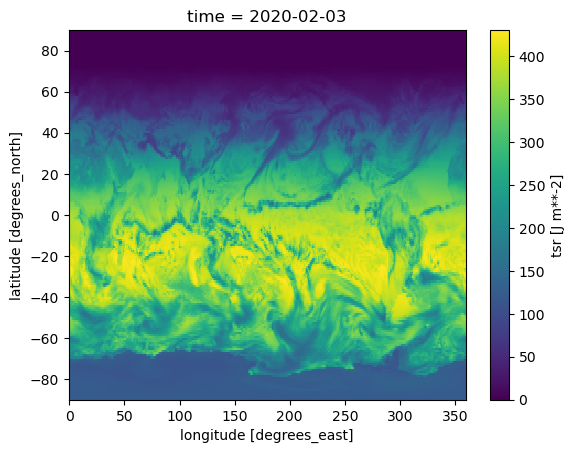

In [22]:
clean[14,:,:].plot()

# Second test: catalog full resolution
Big call from the catalog, very slow. We load the catalog, ask for daily mean and regrid to r100. This is quite intensive already

In [51]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", regrid='r100')
data = reader.retrieve(fix=False)
xfield = data['tsr']

Here we can check if we need to use the decumulate. We activate the decumulation, which takes 100seconds which is A LOT. However, it works

In [52]:
if check_cumulate(xfield): 
    #clean = decumulate(xfield)
    clean = decumulate_fast(xfield)
clean

<xarray.DataArray 'time' (time: 13)>
array(['2020-01-20T00:00:00.000000000', '2020-01-20T01:00:00.000000000',
       '2020-02-01T01:00:00.000000000', '2020-03-01T01:00:00.000000000',
       '2020-04-01T01:00:00.000000000', '2020-05-01T01:00:00.000000000',
       '2020-06-01T01:00:00.000000000', '2020-07-01T01:00:00.000000000',
       '2020-08-01T01:00:00.000000000', '2020-09-01T01:00:00.000000000',
       '2020-10-01T01:00:00.000000000', '2020-11-01T01:00:00.000000000',
       '2020-12-01T01:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 ... 2020-12-01T01:00:00


<xarray.DataArray 'tsr' (time: 8329, value: 26306560)>
dask.array<where, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/16)
    paramId:                    178
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfName:                     toa_net_upward_shortwave_flux
    cfVarName:                  tsr
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

Then we apply regridding. Unless we miss something, keep in mind that we need to decumulate before averaging.

In [53]:
reg = reader.regrid(clean)
reg

<xarray.DataArray 'tsr' (time: 8329, lat: 180, lon: 360)>
dask.array<reshape, shape=(8329, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/17)
    paramId:                    178
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfVarName:                  tsr
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1

We finally decide to plot a single daily frame. The operation has become too slow than previous commit, unclear why. but it seems still correct.

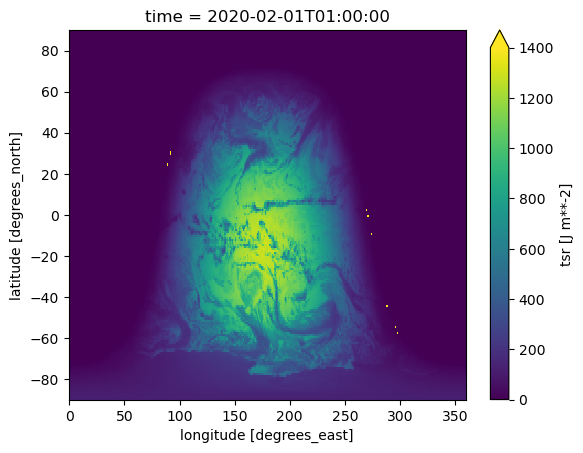

In [54]:
reg[289,:,:].plot(vmin=0, vmax=1400)